In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-mnist/AbdomenCT/003646.jpeg
/kaggle/input/medical-mnist/AbdomenCT/003998.jpeg
/kaggle/input/medical-mnist/AbdomenCT/001273.jpeg
/kaggle/input/medical-mnist/AbdomenCT/001609.jpeg
/kaggle/input/medical-mnist/AbdomenCT/007646.jpeg
/kaggle/input/medical-mnist/AbdomenCT/002415.jpeg
/kaggle/input/medical-mnist/AbdomenCT/003732.jpeg
/kaggle/input/medical-mnist/AbdomenCT/002082.jpeg
/kaggle/input/medical-mnist/AbdomenCT/001430.jpeg
/kaggle/input/medical-mnist/AbdomenCT/007265.jpeg
/kaggle/input/medical-mnist/AbdomenCT/008476.jpeg
/kaggle/input/medical-mnist/AbdomenCT/005745.jpeg
/kaggle/input/medical-mnist/AbdomenCT/007326.jpeg
/kaggle/input/medical-mnist/AbdomenCT/008356.jpeg
/kaggle/input/medical-mnist/AbdomenCT/000971.jpeg
/kaggle/input/medical-mnist/AbdomenCT/000631.jpeg
/kaggle/input/medical-mnist/AbdomenCT/008560.jpeg
/kaggle/input/medical-mnist/AbdomenCT/003601.jpeg
/kaggle/input/medical-mnist/AbdomenCT/003509.jpeg
/kaggle/input/medical-mnist/AbdomenCT/008940.jpeg


# Medical MNIST Dataset

In [8]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define Transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # convert imgs into grayscale
    transforms.Resize((64,64)), # resize imgs into 64x64
    transforms.ToTensor(), #convert to tensor
    transforms.Normalize((0.5,),(0.5,)) # Normalize to [-1,1]   
])

# path to dataset 
dataset_path = '/kaggle/input/medical-mnist'

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root = dataset_path, transform=transform)

# Split dataset into training and testing
train_size = int(0.8 * len(dataset)) # 80% for training
test_size = len(dataset) - train_size # 20% for testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# get class names
class_names = dataset.classes
print("Classes : ", class_names)

Classes :  ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


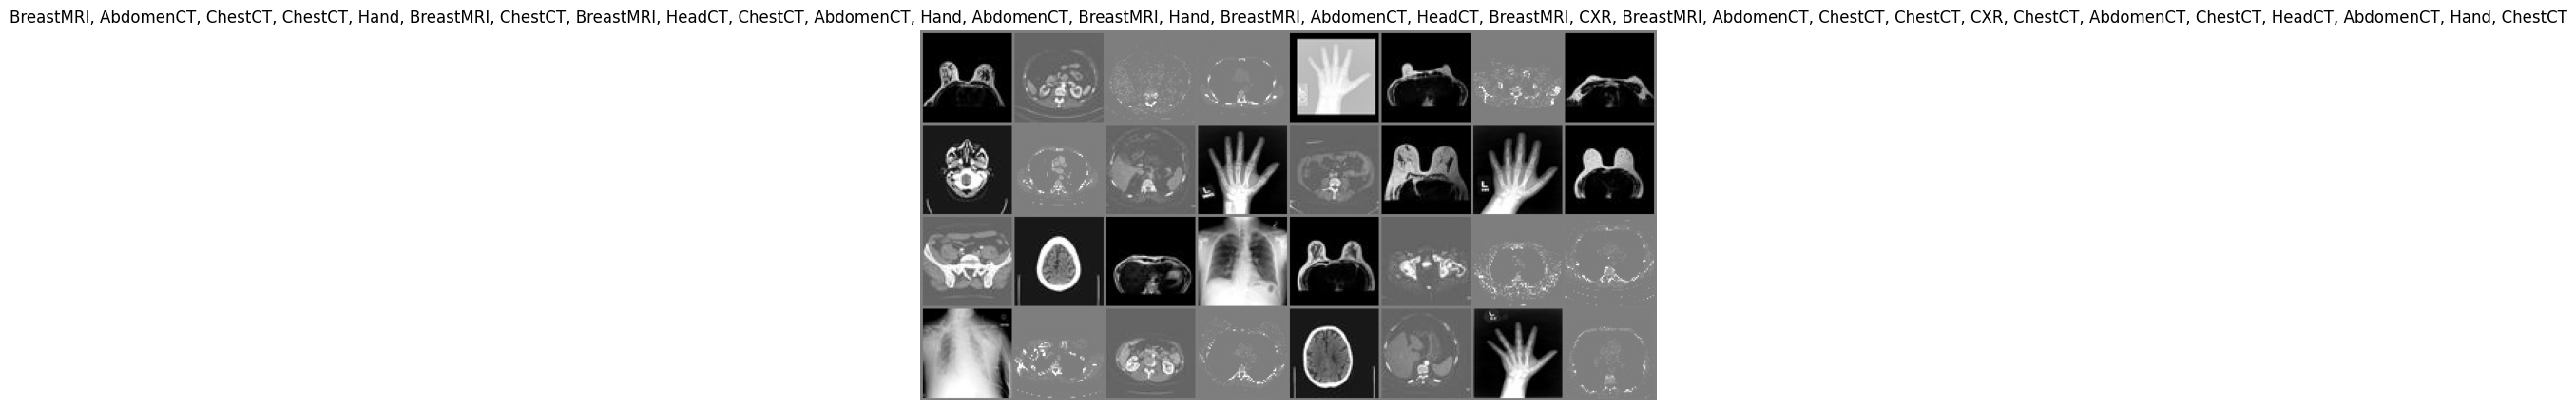

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid  # Import make_grid directly

# Helper function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))  # Adjust figure size for better visualization
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(", ".join(title))  # Display class names as a single string
    plt.axis('off')  # Turn off axis for cleaner visualization
    plt.show()

# Display a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show images
imshow(make_grid(images), title=[class_names[label] for label in labels])


# ANN 

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [30]:
class MedicalMnistModel(nn.Module):
    def __init__(self, num_classes):
        super(MedicalMnistModel, self).__init__()
        # Flatten input directly into Fully Connected Layer(fcn)
        self.fc1 = nn.Linear(1 * 64 * 64, 128) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)


    def forward(self, x):
        x = x.view(x.size(0),-1) # flatten the input img (64x64)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)

        return x

In [ ]:
# initialize the model
num_classes = len(class_names) # set the number of classes based on the dataset
model = MedicalMnistModel(num_classes=num_classes).to('cuda') # move model to gpu if available

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 2
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to('cuda'), targets.to('cuda')


        # Flatten the input images for ANN
        inputs = inputs.view(inputs.size(0),-1) # flatten the img into 1D vector


        optimizer.zero_grad() # Clears any previously accumulated gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, targets) # compute loss
        loss.backward() # Backpropagate
        optimizer.step() # update weights


        running_loss += loss.item() # accumulate loss for reporting

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


# Testing
model.eval()
correct = 0
total = 0
with torch.no_grad(): # ensures that no gradients are calculated during the inference phase
    for inputs, targets in test_loader: # Loops over the testing dataset
        inputs, targets = inputs.to('cuda'), targets.to('cuda')

        # Flatten input images for ANN
        inputs = inputs.view(inputs.size(0), -1)  # Flatten the image to a 1D vector

        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Print the accuracy
print(f"Test Accuracy: {100 * correct / total:.2f}%")
        


Epoch 1/2, Loss: 0.0819
Epoch 2/2, Loss: 0.0199
Test Accuracy: 99.53%
